In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('dados/banking.db')
query = """
SELECT
    *
FROM
    variables
"""

variables_limpo = pd.read_sql_query(query, conn)
conn.close()


In [ ]:
variables_limpo['ano'] = pd.to_datetime(variables_limpo['data']).dt.year

dummies_tempo = pd.get_dummies(variables_limpo['ano'], drop_first=False)

dummies_tempo = dummies_tempo.astype(int)
variables_limpo = pd.concat([variables_limpo, dummies_tempo], axis=1)

# dummies_tempo = pd.get_dummies(variables_limpo['data'], drop_first=True)



In [4]:
# Modelo - Primeiro Estágio
import statsmodels.api as sm

# dummies_tempo = pd.get_dummies(variables_limpo['data'], drop_first=True)


dummies_tempo = dummies_tempo.astype(int)
variables_limpo = pd.concat([variables_limpo, dummies_tempo], axis=1)

#colunas_X_originais = ['nibd', 'ibf', 'lever', 'opc', 'liquid', 'servr', 'nibd_lag_1', 'nibd_lag_2', 'nibd_lag_3', 'ibf_lag_1', 'ibf_lag_2', 'ibf_lag_3', 'lever_lag_1', 'lever_lag_2', 'lever_lag_3', 'opc_lag_1', 'opc_lag_2', 'opc_lag_3', 'liquid_lag_1', 'liquid_lag_2', 'liquid_lag_3', 'servr_lag_1', 'servr_lag_2', 'servr_lag_3']
#colunas_X_originais = ['nibd', 'nibra', 'ibf', 'lever', 'opc', 'liquid', 'servr', 'mktsh', 'mktsh_big', 'mktsh_medium', 'mktsh_small']
colunas_X_originais = ['nibd', 'nibra', 'ibf', 'opc', 'servr','mktsh', 'mktsh']
colunas_X = colunas_X_originais + list(dummies_tempo.columns)
X = variables_limpo[colunas_X]
y = variables_limpo['spread']

stage1 = sm.OLS(y, sm.add_constant(X)).fit()
results_stage1 = stage1
print(results_stage1.summary())

spread_estimado = variables_limpo[['data', 'cnpj', 'NOME_INSTITUICAO']]
spread_estimado['spread_estimado'] = results_stage1.predict()
spread_estimado['spread_puro'] = results_stage1.params['const'] + variables_limpo[dummies_tempo.columns].dot(results_stage1.params[dummies_tempo.columns])


                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     694.6
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:40:09   Log-Likelihood:                -53992.
No. Observations:               14028   AIC:                         1.080e+05
Df Residuals:                   14007   BIC:                         1.082e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4157      0.447     45.722      0.0

/tmp/ipykernel_505994/3954779637.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_estimado['spread_estimado'] = results_stage1.predict()
/tmp/ipykernel_505994/3954779637.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_estimado['spread_puro'] = results_stage1.params['const'] + variables_limpo[dummies_tempo.columns].dot(results_stage1.params[dummies_tempo.columns])


/tmp/ipykernel_505994/2666658408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_estimado['residuos'] = pd.DataFrame(results_stage1.resid)


<Figure size 1000x600 with 0 Axes>

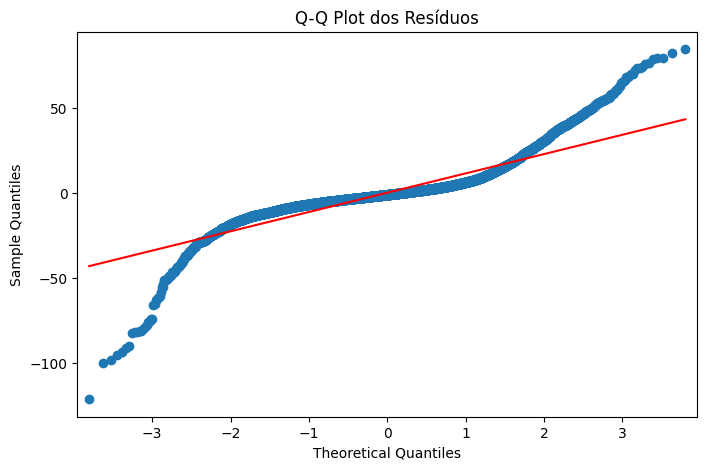

In [5]:
#QQ-plot dos resíduos

import matplotlib.pyplot as plt

spread_estimado['residuos'] = pd.DataFrame(results_stage1.resid)
plt.figure(figsize=(10, 6))

plt.figure(figsize=(8, 5))
sm.qqplot(spread_estimado['residuos'], line='s', ax=plt.gca()) # 's' força a linha a passar pelos pontos esperados
plt.title('Q-Q Plot dos Resíduos')
plt.show()

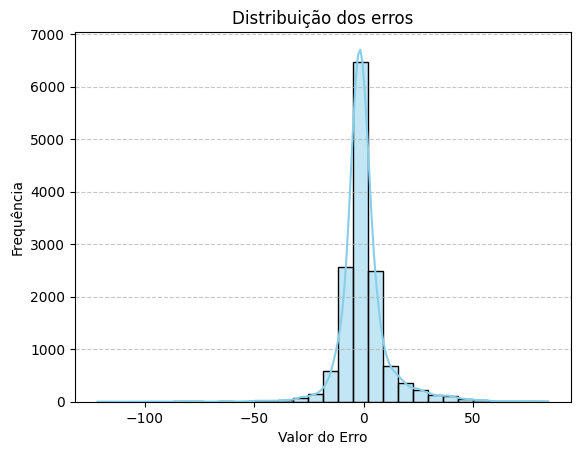

In [6]:
# Histograma dos resíduos com Seaborn
import seaborn as sns

# O 'kde=True' adiciona a Curva de Densidade de Kernel sobre o histograma
sns.histplot(
    data=spread_estimado,
    x='residuos',
    bins=30,           # Número de barras
    kde=True,          # Adiciona a Curva de Densidade de Kernel
    color='skyblue',
    edgecolor='black'
)

plt.title('Distribuição dos erros')
plt.xlabel('Valor do Erro')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# Usando a função Jarque-Bera de SciPy
from scipy import stats

# stats.jarque_bera retorna: (Estatística JB, p-valor, Skewness, Kurtosis)
jb_test = stats.jarque_bera(spread_estimado['residuos'])

print("\n--- Teste de Jarque-Bera ---")
print(f"Estatística JB: {jb_test[0]:.4f}")
print(f"P-valor: {jb_test[1]:.4f}")

# Interpretação
alfa = 0.05
if jb_test[1] < alfa:
    print("Rejeitamos H0: Os resíduos NÃO são normalmente distribuídos.")
else:
    print("NÃO rejeitamos H0: Os resíduos são normalmente distribuídos (ou não há evidência contrária).")


--- Teste de Jarque-Bera ---
Estatística JB: 81514.3572
P-valor: 0.0000
Rejeitamos H0: Os resíduos NÃO são normalmente distribuídos.


In [8]:
# Usando a função Shapiro-Wilk de SciPy
# stats.shapiro retorna: (Estatística W, p-valor)
shapiro_test = stats.shapiro(spread_estimado['residuos'])

print("\n--- Teste de Shapiro-Wilk ---")
print(f"Estatística W: {shapiro_test[0]:.4f}")
print(f"P-valor: {shapiro_test[1]:.4f}")

# Interpretação
if shapiro_test[1] < alfa:
    print("Rejeitamos H0: Os resíduos NÃO são normalmente distribuídos.")
else:
    print("NÃO rejeitamos H0: Os resíduos são normalmente distribuídos.")


--- Teste de Shapiro-Wilk ---
Estatística W: 0.8209
P-valor: 0.0000
Rejeitamos H0: Os resíduos NÃO são normalmente distribuídos.


/home/hspassos/anaconda3/envs/bcb/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14028.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
print(spread_estimado['residuos'].mean())
print(spread_estimado['residuos'].median())
print(spread_estimado['residuos'].std())


9.86290857621947e-15
-1.1776953181657095
11.358156532379024


In [10]:

# colunas_X_originais = ['nibd', 'nibra', 'ibf', 'lever', 'opc', 'servr']

colunas_X_originais = ['nibd', 'nibra', 'opc', 'servr', 'ibf', 'mktsh']
colunas_X = colunas_X_originais + list(dummies_tempo.columns)
X = variables_limpo[colunas_X]

stage1_hc3 = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3')
print(stage1_hc3.summary())

                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     714.3
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:42:08   Log-Likelihood:                -53992.
No. Observations:               14028   AIC:                         1.080e+05
Df Residuals:                   14007   BIC:                         1.082e+05
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4157      0.587     34.799      0.0

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variável"] = variables_limpo[colunas_X_originais].columns

# Calcule o VIF para cada coluna
# A iteração deve ser feita pelo índice numérico da coluna
vif_data["VIF"] = [variance_inflation_factor(variables_limpo[colunas_X_originais].values, i) 
                    for i in range(variables_limpo[colunas_X_originais].shape[1])]

# Ordene por VIF decrescente para identificar os maiores problemas
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print("\n--- Resultados do VIF ---")
print(vif_data)



--- Resultados do VIF ---
  Variável       VIF
4      ibf  2.671217
2      opc  1.905345
1    nibra  1.559796
0     nibd  1.524566
3    servr  1.438888
5    mktsh  1.195919


In [12]:
vif_data = pd.DataFrame()
vif_data["Variável"] = variables_limpo[colunas_X].columns

# Calcule o VIF para cada coluna
# A iteração deve ser feita pelo índice numérico da coluna
vif_data["VIF"] = [variance_inflation_factor(variables_limpo[colunas_X].values, i) 
                    for i in range(variables_limpo[colunas_X].shape[1])]

# Ordene por VIF decrescente para identificar os maiores problemas
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print("\n--- Resultados do VIF ---")
print(vif_data)



--- Resultados do VIF ---
   Variável       VIF
18     2022  2.712603
19     2023  2.704361
20     2024  2.692237
16     2020  2.642350
17     2021  2.641347
7      2011  2.585805
14     2018  2.575776
15     2019  2.569715
8      2012  2.550822
11     2015  2.528642
6      2010  2.521158
12     2016  2.512418
9      2013  2.476459
13     2017  2.475508
10     2014  2.438676
4       ibf  1.386256
3     servr  1.350071
1     nibra  1.198690
0      nibd  1.168131
2       opc  1.140664
5     mktsh  1.128785


In [13]:
# Segundo Estágio - CDI

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    cdi_estimado
"""

cdi = pd.read_sql_query(query, conn)

conn.close()

In [14]:
spread_puro = spread_estimado[['data', 'spread_puro']].drop_duplicates()
spread_puro['spread_puro'] = spread_puro['spread_puro']
spread_puro['cdi'] = spread_puro['data'].map(cdi.set_index('data')['cdi'])

spread_puro = pd.merge(
    spread_puro,
    cdi[['data', 'cond_vol']],
    on=['data'],
    how='left'
)

#spread_puro = spread_puro.dropna(how='any', subset='cond_vol')


In [15]:
# PIM-PF
import ipeadatapy as ipea

pim = ipea.timeseries('PIMPFN12_QIIGSNNAS12')
pim['data'] = pim.index
pim['data'] = pd.to_datetime(pim['data'], format='%Y-%m').dt.strftime('%Y-%m')
pim = pim.rename(columns={'VALUE (-)': 'pim'})
#pim['pim'] = pim['pim'] * 100
pim['pim-pf'] = pim['pim'].pct_change() * 100

spread_puro = pd.merge(
    spread_puro,
    pim[['data', 'pim-pf']],
    on=['data'],
    how='left'
)


In [16]:
# Inflação (IPCA)

inflacao = ipea.timeseries('PAN12_IPCAG12')
inflacao['data'] = inflacao.index
inflacao['data'] = pd.to_datetime(inflacao['data'], format='%Y-%m').dt.strftime('%Y-%m')
inflacao = inflacao.rename(columns={'VALUE ((% a.a.))': 'ipca'})
inflacao['ipca'] = inflacao['ipca'] * 100

spread_puro = pd.merge(
    spread_puro,
    inflacao[['data', 'ipca']],
    on=['data'],
    how='left'
)

spread_puro = spread_puro.dropna(how='any', subset=['cond_vol'])


In [17]:
X = spread_puro[['cdi', 'cond_vol', 'pim-pf', 'ipca']]
y = spread_puro['spread_puro']

reg = sm.OLS(y, sm.add_constant(X)).fit()
results_reg = reg
print(results_reg.summary())

                            OLS Regression Results                            
Dep. Variable:            spread_puro   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     38.54
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           5.25e-23
Time:                        19:45:02   Log-Likelihood:                -306.88
No. Observations:                 177   AIC:                             623.8
Df Residuals:                     172   BIC:                             639.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.3557      0.383     66.117      0.0